# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [ ]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 3

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [ ]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Inputting x1, x2, r, x1^2, x2^2 and x1*x2 for better undersatnding the location of point, angular variation along with the distance form the centre
# Can also be called as Feature Engineering
x_numpy = np.asarray(X_full)
y_numpy = np.asarray(y_full)
x1 = x_numpy[:, 0]
x2 = x_numpy[:, 1]
r = np.sqrt(x1**2 + x2**2)
x1_sq = x1**2
x2_sq = x2**2
x1x2  = x1 * x2

x_stacked = np.column_stack([x1, x2, r, x1_sq, x2_sq, x1x2])

# Train-Test splitting
x_train, x_test, y_train, y_test = train_test_split(x_stacked, y_numpy, test_size=0.3, random_state=42)

x_train = torch.tensor(x_train, dtype=torch.float32) # COnverting them to toirch tensors
x_test  = torch.tensor(x_test,  dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

# Doing Standardisation using StandardScaler Manual
scaler = StandardScaler()
x_train = torch.tensor(scaler.fit_transform(x_train.numpy()), dtype=torch.float32)
x_test  = torch.tensor(scaler.transform(x_test.numpy()), dtype=torch.float32)

# MLP Parameters
w1 = torch.randn(6, 16)*np.sqrt(2 / 6) # Multiplying this for avoiding weight explosion i.e., preventing the weights to become very large or very small
w1.requires_grad_()
b1 = torch.zeros(16, requires_grad=True)

w2 = torch.randn(16, 16)*np.sqrt(2 / 16) # Multiplying this for avoiding weight explosion i.e., preventing the weights to become very large or very small
w2.requires_grad_()
b2 = torch.zeros(16, requires_grad=True)

w3 = torch.randn(16, 16)*np.sqrt(2 / 16) # Multiplying this for avoiding weight explosion i.e., preventing the weights to become very large or very small
w3.requires_grad_()
b3 = torch.zeros(16, requires_grad=True)

w4 = torch.randn(16, 1)*np.sqrt(2 / 16) # Multiplying this for avoiding weight explosion i.e., preventing the weights to become very large or very small
w4.requires_grad_()
b4 = torch.zeros(1, requires_grad=True)

parameters = [w1, b1, w2, b2, w3, b3, w4, b4]

# Training Parameters
learning_rate = 0.01
num_epochs = 500
eps = 1e-8 # For tackling the log(0) case
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Adding L2 regularization for better geometrical adaptation and keeping the weights small
lambda_l2 = 1e-3

# Training loop
for epoch in range(num_epochs):

    # Forward passing
    a1 = torch.relu(torch.matmul(x_train, w1) + b1)
    a2 = torch.relu(torch.matmul(a1, w2) + b2)
    a3 = torch.relu(torch.matmul(a2, w3) + b3)
    probs = torch.sigmoid(torch.matmul(a3, w4) + b4)

    bce_loss = -torch.mean(y_train*torch.log(probs+eps)+(1-y_train)*torch.log(1-probs+eps))

    # Adding the L2 regularization
    l2_penalty = ((w1**2).sum()+(w2**2).sum()+(w3**2).sum()+(w4**2).sum())

    loss = bce_loss + lambda_l2*l2_penalty
    train_losses.append(loss.item())

    # The magic happens here (Autograd)
    loss.backward()
    
    # Applying Stochastic Gradient Descent
    with torch.no_grad():
        for p in parameters:
            p -= learning_rate*p.grad
            p.grad.zero_()

    # Training Accuracy
    train_accuracy = ((probs >= 0.5) == y_train).float().mean().item()
    train_acc.append(train_accuracy)

    # Validation
    with torch.no_grad():
        a1v = torch.relu(torch.matmul(x_test, w1) + b1)
        a2v = torch.relu(torch.matmul(a1v, w2) + b2)
        a3v = torch.relu(torch.matmul(a2v, w3) + b3)
        probs_val = torch.sigmoid(torch.matmul(a3v, w4) + b4)

        val_loss = -torch.mean(y_test * torch.log(probs_val + eps)+(1 - y_test) * torch.log(1 - probs_val + eps))
        val_losses.append(val_loss.item())

        val_accuracy = ((probs_val >= 0.5) == y_test).float().mean().item()
        val_acc.append(val_accuracy)

    if epoch % 40 == 0:
        print(f"Epoch {epoch:3d} | " f"Train Loss: {loss.item():.4f} | " f"Val Loss: {val_loss.item():.4f} | " f"Train Acc: {train_accuracy:.4f} | " f"Val Acc: {val_accuracy:.4f}")

# Final Test Accuracy
with torch.no_grad():
    preds = (probs_val >= 0.5)
    final_accuracy = (preds == y_test).float().mean().item()

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")


Epoch   0 | Train Loss: 0.8836 | Val Loss: 0.7759 | Train Acc: 0.4824 | Val Acc: 0.4844
Epoch  40 | Train Loss: 0.7209 | Val Loss: 0.6140 | Train Acc: 0.6495 | Val Acc: 0.6578
Epoch  80 | Train Loss: 0.6672 | Val Loss: 0.5577 | Train Acc: 0.7400 | Val Acc: 0.7467
Epoch 120 | Train Loss: 0.6293 | Val Loss: 0.5176 | Train Acc: 0.7814 | Val Acc: 0.7933
Epoch 160 | Train Loss: 0.6007 | Val Loss: 0.4872 | Train Acc: 0.8076 | Val Acc: 0.8078
Epoch 200 | Train Loss: 0.5786 | Val Loss: 0.4630 | Train Acc: 0.8210 | Val Acc: 0.8333
Epoch 240 | Train Loss: 0.5603 | Val Loss: 0.4432 | Train Acc: 0.8333 | Val Acc: 0.8489
Epoch 280 | Train Loss: 0.5448 | Val Loss: 0.4266 | Train Acc: 0.8476 | Val Acc: 0.8589
Epoch 320 | Train Loss: 0.5311 | Val Loss: 0.4122 | Train Acc: 0.8576 | Val Acc: 0.8689
Epoch 360 | Train Loss: 0.5189 | Val Loss: 0.3993 | Train Acc: 0.8648 | Val Acc: 0.8756
Epoch 400 | Train Loss: 0.5080 | Val Loss: 0.3877 | Train Acc: 0.8757 | Val Acc: 0.8811
Epoch 440 | Train Loss: 0.4981 |

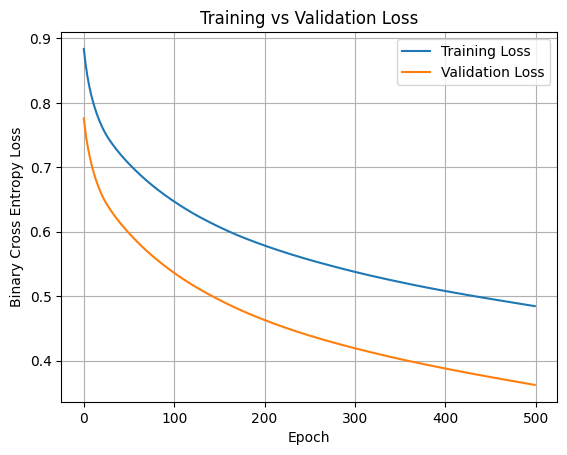

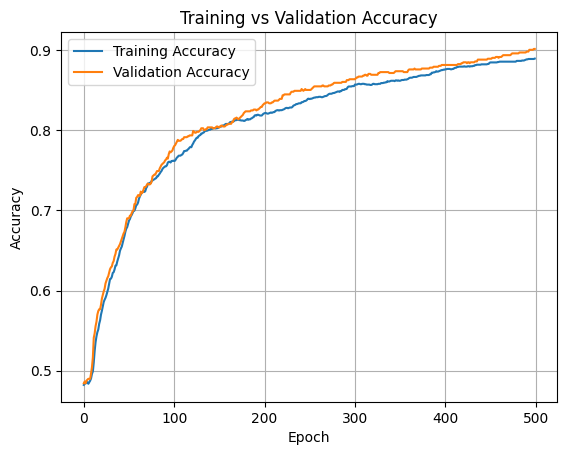

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(train_acc))
# Plotting the Train Losses vs Validation losses across all the epochs
plt.figure()
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Accuracy Curves
plt.figure()
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

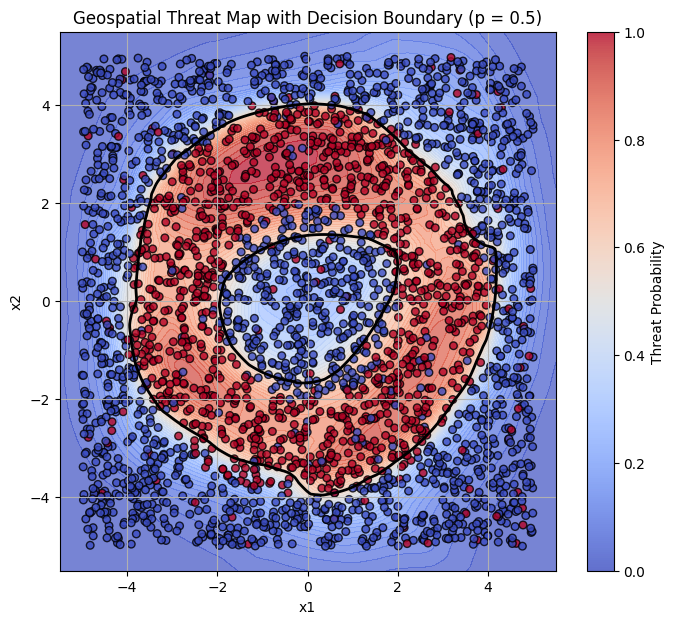

In [ ]:
# For plotting the grid
x_val = x_numpy[:, 0]
y_val = x_numpy[:, 1]
x_min, x_max = x_val.min() - 0.5, x_val.max() + 0.5
y_min, y_max = y_val.min() - 0.5, y_val.max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),np.linspace(y_min, y_max, 400))

# Doing the feature engineering on the grid
x1g = xx.ravel()
x2g = yy.ravel()
rg     = np.sqrt(x1g**2 + x2g**2)
x1g_sq = x1g**2
x2g_sq = x2g**2
x1x2g  = x1g * x2g

x_grid = np.column_stack([x1g, x2g, rg, x1g_sq, x2g_sq, x1x2g])

# Standardization
x_grid_scaled = scaler.transform(x_grid)
x_grid_scaled = torch.tensor(x_grid_scaled, dtype=torch.float32)

# Doing the Forward Pass
with torch.no_grad():
    a1 = torch.relu(torch.matmul(x_grid_scaled, w1) + b1)
    a2 = torch.relu(torch.matmul(a1, w2) + b2)
    a3 = torch.relu(torch.matmul(a2, w3) + b3)
    probs_grid = torch.sigmoid(torch.matmul(a3, w4) + b4)

Z = probs_grid.numpy().reshape(xx.shape)

plt.figure(figsize=(8, 7))
# Geospatial Threat probability heatmap
plt.contourf(xx, yy, Z, levels=50, cmap="coolwarm", alpha=0.7)

# Plotting the Decision boundary at p = 0.5
plt.contour(xx, yy, Z,levels=[0.5],colors="black",linewidths=2)

# Validation points
plt.scatter(x_numpy[:, 0], x_numpy[:, 1], c=y_numpy, cmap="coolwarm", edgecolors="k", s=30, alpha=0.8)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Geospatial Threat Map with Decision Boundary (p = 0.5)")
plt.colorbar(label="Threat Probability")
plt.grid(True)
plt.show()
